# Process Reddit posts

Reddit threads have been collected with the script `get_subreddit_ids.py` and stored in files named `submissions_ids_ThreadName.txt`. The IDs of the Megathread have been collected manually. Next, subreddit posts have been collected with the script `coronamessagesnl.py` and stored in the directory `downloads`. Threads from different downloads directories have been combined with the script `combineRedditPosts.py`.

In [1]:
import csv
import datetime
import os
import pandas as pd
import pipes
import re
import sys
import tempfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer

In [2]:
DATADIRIN = "../data/reddit/downloads/"
DATADIRTEXT = "../data/reddit/text/"
DATEFORMATOUT = "%Y%m%d-%H"
SUBREDDIT = "subreddit"
CREATED = "created"
ID = "id"
AUTHOR = "author"
BODY = "body"
PARENT = "parent"
FILESUFFIX = ".out.gz"
IDSTR = "id_str"
REPLYID = "in_reply_to_status_id_str"
USER = "user"
VERIFIED = "verified"
TEXT = "text"
DELETED = "[deleted]"
REMOVED = "[removed]"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [4]:
def makeDateString(date):
    return(datetime.datetime.strftime(datetime.datetime.fromtimestamp(date),DATEFORMATOUT))

In [5]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

## Language identification with langid

In [6]:
import langid

In [7]:
NL = "nl"
DE = "de"
AF = "af"

## Get all posts from downloaded files

In [8]:
posts = []
files = sorted(os.listdir(DATADIRIN))
for i in range(0,len(files)):
    inFileName = files[i]
    squeal(" ".join([str(i),str(len(posts)),inFileName]))
    try:
        df = pd.read_csv(DATADIRIN+inFileName)
    except:
        next
    for j in range(0,len(df)):
        date = df.iloc[j][CREATED]
        subReddit = df.iloc[j][SUBREDDIT]
        idStr = subReddit+"_"+df.iloc[j][ID]
        parent = subReddit+"_"+df.iloc[j][PARENT].split("_")[1]
        user = df.iloc[j][AUTHOR]
        text = re.sub(r"\n"," ",df.iloc[j][BODY])
        if text == DELETED or text == REMOVED: continue
        preprocessedText = preprocess(text)
        language = langid.classify(preprocessedText)[0]
        if language in [NL,AF,DE]:
            posts.append((makeDateString(date),idStr,parent,user,None,text))
squeal(" ".join([str(i),str(len(posts))]))

2084 61371


## Store all posts in hour files

In [27]:
verified = ""
dataPerHour = {}
monthCounts = {}
for i in range(0,len(posts)):
    if i%1000 == 0: squeal(i)
    post = posts[i]
    date = post[0]
    idStr = post[1]
    replyId = post[2]
    user = post[3]
    text = re.sub(r"\r"," ",re.sub(r"\n"," ",post[5]))
    if not date in dataPerHour: dataPerHour[date] = []
    data = {IDSTR:idStr,REPLYID:replyId,USER:user,VERIFIED:verified,TEXT:text}
    if not data in dataPerHour[date]: 
        dataPerHour[date].append(data)
        month = date[0:6]
        if not month in monthCounts: monthCounts[month] = 0
        monthCounts[month] += 1
squeal(i)

61370


In [32]:
for month in sorted(monthCounts.keys()):
    print(f"{month}: {monthCounts[month]}")

202002: 5
202003: 27997
202004: 11938
202005: 6441
202006: 3214
202007: 2929
202008: 4722
202009: 1484


In [14]:
for date in sorted(dataPerHour.keys()):
    squeal(date)
    outFileName = DATADIRTEXT+date+FILESUFFIX
    pd.DataFrame(dataPerHour[date]).to_csv(outFileName,index=False,compression="gzip")

20200915-12


## Visualize number of posts per day

In [15]:
def fileNameToHourString(fileName):
    return(fileName[0:11])

dataPerHour = {}
inFileNames = sorted(os.listdir(DATADIRTEXT))
for inFileName in inFileNames:
    squeal(inFileName)
    hourString = fileNameToHourString(inFileName)
    df = pd.read_csv(DATADIRTEXT+inFileName)
    dataPerHour[hourString] = list(df.T.to_dict(orient="dict").values())

20200915-12.out.gz


In [16]:
postsDays = []
for post in posts:
    post = list(post)
    post[0] = post[0][:8]
    postsDays.append(post)

In [17]:
df = pd.DataFrame(postsDays)
groups = df.groupby(0).groups
dates = {f:len(groups[f]) for f in groups}

In [18]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

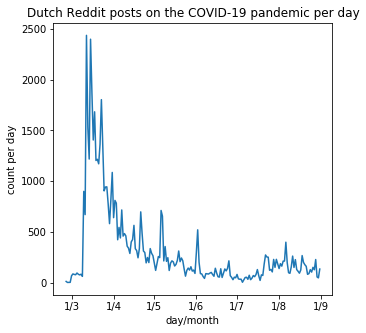

In [19]:
DATEFORMATDAY = "%Y%m%d"
PLOTFILENAME = "frequency-reddit.png"
UNTILDATE = "20200901"

x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in dates if d < UNTILDATE]
y = [dates[d] for d in dates if d < UNTILDATE]

fig,ax = plt.subplots(figsize=(5,5))
plt.plot_date(x,y,fmt="-")
plt.xlabel("day/month")
plt.ylabel("count per day")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.title("Dutch Reddit posts on the COVID-19 pandemic per day")
plt.savefig(PLOTFILENAME)
plt.show()

## Visualize query words

In [20]:
TOPIC = "topic"
QUERYLIST = ("corona covid mondkapje rivm blijfthuis houvol huisarts flattenthecurve "+TOPIC).split()
QUERYTOPIC = "corona|covid|mondkapje|rivm|blijfthuis|houvol|huisarts|flattenthecurve"
TOTAL = "total"

def makeDateFromHour(hour):
    return(hour[0:8])

queryCounts ={}
for query in QUERYLIST:
    queryCounts[query] = {}
    querySearch = query
    if query == TOPIC: querySearch = QUERYTOPIC
    for post in posts:
        text = post[5]
        if re.search(querySearch,text,flags=re.IGNORECASE):
            date = makeDateFromHour(post[0])
            if not date in queryCounts[query]: queryCounts[query][date] = 0
            queryCounts[query][date] += 1

queryCounts[TOTAL] = {}
for post in posts:
    date = makeDateFromHour(post[0])
    if not date in queryCounts[TOTAL]: queryCounts[TOTAL][date] = 0
    queryCounts[TOTAL][date] += 1

totals = {}
for query in QUERYLIST+[TOTAL]:
    totals[query] = sum(queryCounts[query].values())

In [21]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

In [22]:
WEEKSIZE = 7

queryCounts7 = {}
for query in QUERYLIST+[TOTAL]:
    try:
        sortedKeys = list(sorted(queryCounts[query].keys()))
        sortedValues = [queryCounts[query][d] for d in sortedKeys]
        newSortedValues = movingAverage(sortedValues,WEEKSIZE)
        queryCounts7[query] = {sortedKeys[i]:newSortedValues[i] for i in range(0,len(sortedKeys))}
    except: pass

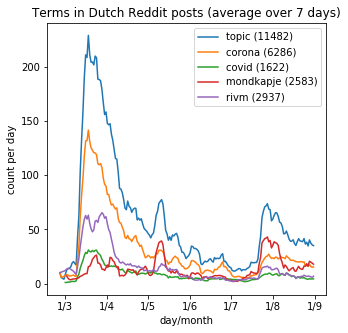

In [23]:
INITDAYSSKIPPED = 0
PLOTFILENAME = "term-frequency-reddit.png"

fig,ax = plt.subplots(figsize=(5,5))
for query in (TOPIC+" corona covid mondkapje rivm").split():
    try:
        x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in queryCounts7[query] if d < UNTILDATE][INITDAYSSKIPPED:]
        y = [queryCounts7[query][d] for d in queryCounts7[query] if d < UNTILDATE][INITDAYSSKIPPED:]
        plt.plot_date(x,y,fmt="-",label=f"{query} ({totals[query]})")
    except: pass
plt.xlabel("day/month")
plt.ylabel("count per day")
plt.title(f"Terms in Dutch Reddit posts (average over {WEEKSIZE} days)")
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()

In [24]:
NBROFCOMBINEDITEMS = 7

def summarizeXY(x,y,nbrOfCombinedItems=NBROFCOMBINEDITEMS):
    summarizedX = []
    summarizedY = []
    yCombined = 0
    for i in range(0,len(y)):
        yCombined += y[i]
        if (i+1)%nbrOfCombinedItems == 0:
            summarizedX.append(x[i])
            summarizedY.append(yCombined)
            yCombined = 0
    if len(y)%nbrOfCombinedItems != 0:
        summarizedX.append(x[i])
        summarizedY.append(yCombined)
    return(summarizedX,summarizedY)

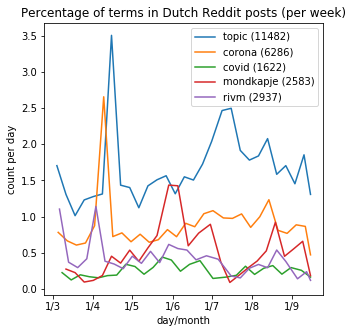

In [25]:
INITDAYSSKIPPED = 0
PLOTFILENAME = "term-percentages-reddit.png"

fig,ax = plt.subplots(figsize=(5,5))
for query in (TOPIC+" corona covid mondkapje rivm").split():
    try:
        x = [datetime.datetime.strptime(d,DATEFORMATDAY) for d in queryCounts7[query]][INITDAYSSKIPPED:]
        y = [queryCounts[query][d]/queryCounts[TOTAL][d] for d in queryCounts[query]][INITDAYSSKIPPED:]
        summarizedX,summarizedY = summarizeXY(x,y)
        plt.plot_date(summarizedX,summarizedY,fmt="-",label=f"{query} ({totals[query]})")
    except: pass
plt.xlabel("day/month")
plt.ylabel("count per day")
plt.title(f"Percentage of terms in Dutch Reddit posts (per week)")
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()